In [3]:
import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv3D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import kagglehub

**Data Preparation Pipeline**

In [4]:
path = kagglehub.dataset_download("rupeshkumaryadav/whu-hyperspectral-dataset")
base_path = path

100%|██████████| 845M/845M [00:09<00:00, 89.8MB/s]

Extracting files...


In [5]:
def apply_PCA(X, num_components=30):
    """Compresses hyperspectral bands using Principal Component Analysis."""
    print(f"Applying PCA: Reducing bands from {X.shape[2]} to {num_components}...")
    original_shape = X.shape
    X_reshaped = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=num_components, whiten=True)
    X_pca = pca.fit_transform(X_reshaped)
    return np.reshape(X_pca, (original_shape[0], original_shape[1], num_components))

In [6]:
def pad_with_zeros(X, margin):
    """Pads the 3D hypercube to prevent edge-extraction errors."""
    new_X = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2 * margin, X.shape[2]))
    new_X[margin:X.shape[0] + margin, margin:X.shape[1] + margin, :] = X
    return new_X

In [7]:
def extract_3d_patches(data, gt, window_size=5):
    """Slices the padded hypercube into 3D geometric patches."""
    print("Extracting 3D spatial patches. Standby...")
    margin = window_size // 2
    padded_data = pad_with_zeros(data, margin)

    X_patches, y_labels = [], []
    for r in range(gt.shape[0]):
        for c in range(gt.shape[1]):
            if gt[r, c] == 0:  # Skip unclassified background dirt
                continue
            patch = padded_data[r : r + window_size, c : c + window_size, :]
            X_patches.append(patch)
            y_labels.append(gt[r, c] - 1)  # Zero-index the labels

    return np.array(X_patches), np.array(y_labels)

In [8]:
def prepare_pipeline(data_path, gt_path, data_key, gt_key, num_classes):
    """Runs the full data pipeline for a given dataset."""
    # Load Data
    data = sio.loadmat(data_path)[data_key]
    gt = sio.loadmat(gt_path)[gt_key]

    # Compress and Extract
    data_pca = apply_PCA(data, num_components=30)
    X_patches, y_labels = extract_3d_patches(data_pca, gt, window_size=5)

    # Format for Keras 3D CNN
    X_patches = X_patches.reshape(-1, 5, 5, 30, 1)
    y_categorical = to_categorical(y_labels, num_classes=num_classes)

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_patches, y_categorical, test_size=0.20, random_state=42, stratify=y_categorical
    )

    return X_train, X_test, y_train, y_test, X_patches, gt

In [9]:
def build_base_3d_cnn(input_shape=(5, 5, 30, 1), num_classes=9):
    """Builds the foundational 3D neural network from scratch."""
    print(f"\n--- BUILDING BASE MODEL ({num_classes} Classes) ---")
    model = Sequential()
    model.add(Conv3D(filters=16, kernel_size=(3, 3, 7), activation='relu', input_shape=input_shape))
    model.add(Conv3D(filters=32, kernel_size=(2, 2, 5), activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax', name='base_output'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

**LONGKOU BASE TRAINING**

In [12]:
lk_data_path = os.path.join(base_path, "WHU-Hi-LongKou", "WHU_Hi_LongKou.mat")
lk_gt_path   = os.path.join(base_path, "WHU-Hi-LongKou", "WHU_Hi_LongKou_gt.mat")


In [ ]:
X_train_lk, X_test_lk, y_train_lk, y_test_lk, _, _ = prepare_pipeline(
    lk_data_path, lk_gt_path, 'WHU_Hi_LongKou', 'WHU_Hi_LongKou_gt', num_classes=9
)

Applying PCA: Reducing bands from 270 to 30...
Extracting 3D spatial patches. Standby...


In [ ]:
base_model = build_base_3d_cnn(num_classes=9)
print("Training LongKou Base Model...")
base_model.fit(X_train_lk, y_train_lk, batch_size=128, epochs=10, validation_data=(X_test_lk, y_test_lk), verbose=1)


--- BUILDING BASE MODEL (9 Classes) ---
Training LongKou Base Model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 125s 96ms/step - accuracy: 0.9462 - loss: 0.1702 - val_accuracy: 0.9984 - val_loss: 0.0064
Epoch 2/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 121s 94ms/step - accuracy: 0.9969 - loss: 0.0106 - val_accuracy: 0.9983 - val_loss: 0.0065
Epoch 3/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 139s 92ms/step - accuracy: 0.9979 - loss: 0.0083 - val_accuracy: 0.9988 - val_loss: 0.0037
Epoch 4/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 133s 86ms/step - accuracy: 0.9986 - loss: 0.0051 - val_accuracy: 0.9991 - val_loss: 0.0035
Epoch 5/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 143s 87ms/step - accuracy: 0.9985 - loss: 0.0053 - val_accuracy: 0.9989 - val_loss: 0.0050
Epoch 6/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 111s 87ms/step - accuracy: 0.9988 - loss: 0.0046 - val_accuracy: 0.9987 - val_loss: 0.0063
Epoch 7/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 111s 87ms/step - accuracy: 0.9986 - loss: 0.0053 - val_accuracy: 0.9984 - val_loss: 0.0074
Epoch 8/10
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 111s 87ms/step - accuracy: 

**HANCHUAN TRANSFER LEARNING**

In [13]:
hc_data_path = os.path.join(base_path, "WHU-Hi-HanChuan", "WHU_Hi_HanChuan.mat")
hc_gt_path   = os.path.join(base_path, "WHU-Hi-HanChuan", "WHU_Hi_HanChuan_gt.mat")

In [ ]:
X_train_hc, X_test_hc, y_train_hc, y_test_hc, X_patches_hc, hc_gt = prepare_pipeline(
    hc_data_path, hc_gt_path, 'WHU_Hi_HanChuan', 'WHU_Hi_HanChuan_gt', num_classes=16
)

print("\n--- PERFORMING MODEL SURGERY IN MEMORY ---")
transfer_model = Sequential()

Applying PCA: Reducing bands from 274 to 30...
Extracting 3D spatial patches. Standby...

--- PERFORMING MODEL SURGERY IN MEMORY ---


In [ ]:
for layer in base_model.layers[:-1]:
    layer.trainable = False
    transfer_model.add(layer)

# Graft new 16-class head
transfer_model.add(Dense(16, activation='softmax', name='hanchuan_16_classes'))
transfer_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

print("Training the new 16-class HanChuan head...")
transfer_model.fit(X_train_hc, y_train_hc, batch_size=128, epochs=10, validation_data=(X_test_hc, y_test_hc), verbose=1)

print("\n--- INITIATING FINE-TUNING PROTOCOL ---")
# Unfreeze the whole brain
for layer in transfer_model.layers:
    layer.trainable = True

# Microscopic learning rate
transfer_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
transfer_model.fit(X_train_hc, y_train_hc, batch_size=128, epochs=10, validation_data=(X_test_hc, y_test_hc), verbose=1)

Training the new 16-class HanChuan head...
Epoch 1/10
1610/1610 ━━━━━━━━━━━━━━━━━━━━ 68s 42ms/step - accuracy: 0.1850 - loss: 5.8421 - val_accuracy: 0.6583 - val_loss: 1.2884
Epoch 2/10
1610/1610 ━━━━━━━━━━━━━━━━━━━━ 58s 36ms/step - accuracy: 0.5469 - loss: 1.9276 - val_accuracy: 0.7439 - val_loss: 0.9060
Epoch 3/10
1610/1610 ━━━━━━━━━━━━━━━━━━━━ 82s 36ms/step - accuracy: 0.6419 - loss: 1.3039 - val_accuracy: 0.7824 - val_loss: 0.7645
Epoch 4/10
1610/1610 ━━━━━━━━━━━━━━━━━━━━ 90s 41ms/step - accuracy: 0.6949 - loss: 1.0376 - val_accuracy: 0.7975 - val_loss: 0.7023
Epoch 5/10
1610/1610 ━━━━━━━━━━━━━━━━━━━━ 73s 36ms/step - accuracy: 0.7216 - loss: 0.9175 - val_accuracy: 0.8063 - val_loss: 0.6694
Epoch 6/10
1610/1610 ━━━━━━━━━━━━━━━━━━━━ 67s 42ms/step - accuracy: 0.7361 - loss: 0.8644 - val_accuracy: 0.8118 - val_loss: 0.6506
Epoch 7/10
1610/1610 ━━━━━━━━━━━━━━━━━━━━ 58s 36ms/step - accuracy: 0.7412 - loss: 0.8387 - val_accuracy: 0.8138 - val_loss: 0.6391
Epoch 8/10
1610/1610 ━━━━━━━━━━━━

**MAP VISUALIZATION**


--- GENERATING FINAL FINE-TUNED MAP ---
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 54s 54ms/step


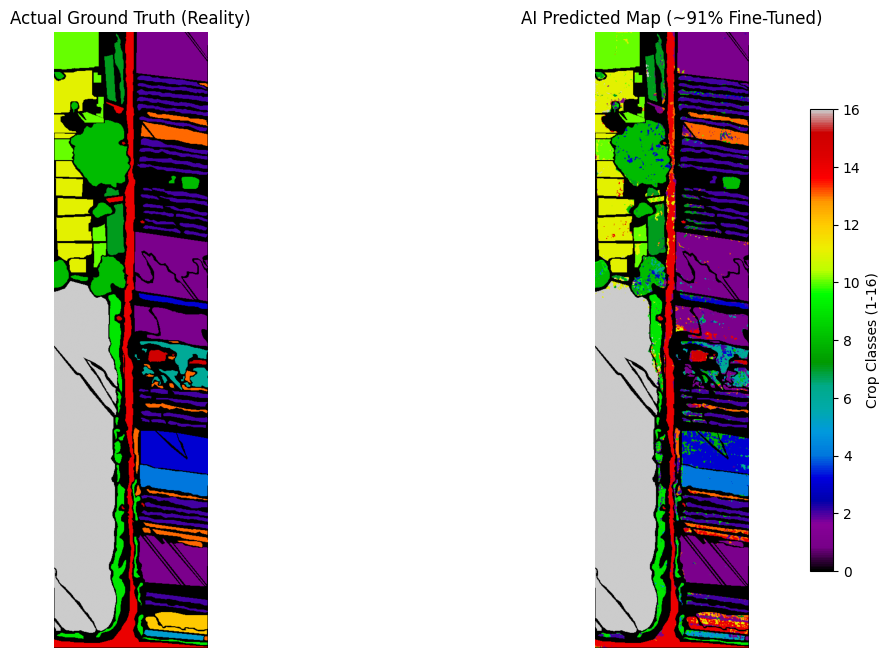

In [ ]:
print("\n--- GENERATING FINAL FINE-TUNED MAP ---")
all_predictions = transfer_model.predict(X_patches_hc, batch_size=256)
predicted_classes = np.argmax(all_predictions, axis=-1) + 1

predicted_map = np.zeros((hc_gt.shape[0], hc_gt.shape[1]))
patch_idx = 0

for r in range(hc_gt.shape[0]):
    for c in range(hc_gt.shape[1]):
        if hc_gt[r, c] == 0:
            continue
        predicted_map[r, c] = predicted_classes[patch_idx]
        patch_idx += 1

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im1 = axes[0].imshow(hc_gt, cmap='nipy_spectral')
axes[0].set_title("Actual Ground Truth (Reality)")
axes[0].axis('off')

im2 = axes[1].imshow(predicted_map, cmap='nipy_spectral')
axes[1].set_title("AI Predicted Map (~91% Fine-Tuned)")
axes[1].axis('off')

fig.colorbar(im1, ax=axes.ravel().tolist(), shrink=0.75, label='Crop Classes (1-16)')
plt.show()